# Loading the data as a time series

In [1]:
import numpy as np
# import mne
from scipy.io import loadmat
from scipy.signal import decimate
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from eeg_utils import *
%matplotlib inline

In [2]:
mat = mat_to_dataframe("sub-0cGdk9_HoldL_MedOff_run1_LFP_Hilbert/sub_AbzsOg_HoldL_MedOn_merged_LFP_Hilbert.mat")

--- Processing file: sub_AbzsOg_HoldL_MedOn_merged_LFP_Hilbert.mat ---
Found data matrix. Key: 'selected_channels_signal', Shape: (2, 2277000)
Found labels. Key: 'target_labels'
Labels extracted: ['LFP-right-34', 'LFP-left-56']


--- DataFrame Created Successfully ---
          LFP-right-34  LFP-left-56
Time (s)                           
0.0000        0.516424    -9.728435
0.0005        2.786528   -11.274771
0.0010       -0.885938   -16.734607
0.0015       -1.626585   -18.135531
0.0020       -1.233082   -17.271396

Successfully extracted left LFP channel: 'LFP-left-56'
Successfully extracted right LFP channel: 'LFP-right-34'


In [3]:
df, left_lfp, right_lfp = mat

Time (s)
0.0000       0.516424
0.0005       2.786528
0.0010      -0.885938
0.0015      -1.626585
0.0020      -1.233082
               ...   
1138.4975   -0.335253
1138.4980   -0.672635
1138.4985   -1.298536
1138.4990   -0.053653
1138.4995    0.470035
Name: LFP-right-34, Length: 2277000, dtype: float64
Time (s)
0.0000       -9.728435
0.0005      -11.274771
0.0010      -16.734607
0.0015      -18.135531
0.0020      -17.271396
               ...    
1138.4975     8.822554
1138.4980     7.558925
1138.4985     1.981811
1138.4990     3.241877
1138.4995     3.298716
Name: LFP-left-56, Length: 2277000, dtype: float64

Plotting first 5000 samples...


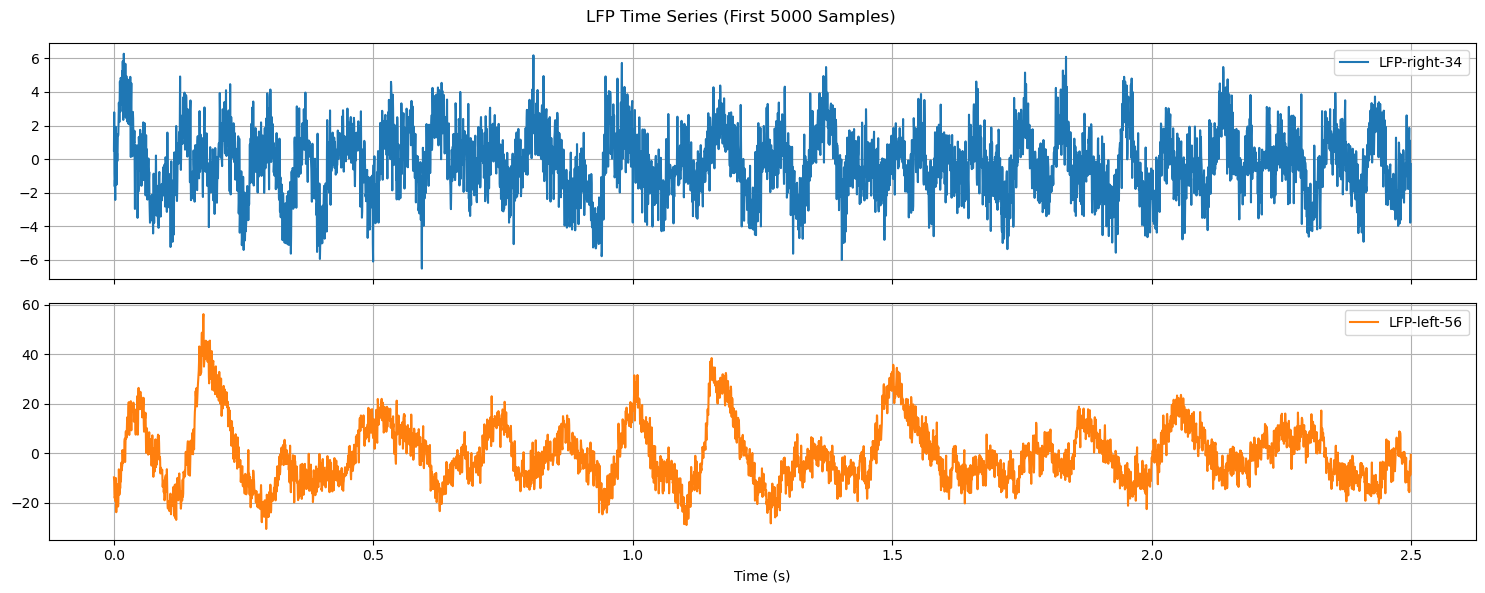

In [4]:
# You can now easily access each channel
# right_lfp = df['LFP-right-34']
# left_lfp = df['LFP-left-56']
right_lfp = df['LFP-right-34']
left_lfp = df['LFP-left-56']
print(right_lfp)
print(left_lfp)
if 'df' in locals():
    print("\nPlotting first 5000 samples...")
    plot_slice = 5000
    
    df.iloc[:plot_slice].plot(
        subplots=True,   # Plot each channel separately
        layout=(2, 1),   # Arrange in 2 rows, 1 column
        grid=True,
        title="LFP Time Series (First 5000 Samples)",
        figsize=(15, 6)  # Width, Height in inches
    )
    plt.xlabel(df.index.name)
    plt.tight_layout()
    plt.show()

In [23]:
type(df)
print(df.head())
print(df.tail())

          LFP-right-34  LFP-left-56
Time (s)                           
0.0000        1.040826     0.850662
0.0005        0.038125     1.269358
0.0010        1.173294     0.220776
0.0015        1.394147     2.182392
0.0020        0.266420     3.403933
           LFP-right-34  LFP-left-56
Time (s)                            
1027.4975      2.547363    -7.389524
1027.4980      4.159000    -7.272926
1027.4985      1.670323    -9.315841
1027.4990     -0.369962    -8.971549
1027.4995      0.041257    -5.683990


Downsampling by a factor of 40...
--- Downsampled DataFrame ---
          LFP-right-34  LFP-left-56
Time (s)                           
0.00          0.618385   -11.327999
0.02          3.814057     0.370468
0.04          1.207164    18.900857
0.06         -0.992770    11.354590
0.08         -1.948503    -1.171801
--- New DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 56925 entries, 0.0 to 1138.48
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LFP-right-34  56925 non-null  float64
 1   LFP-left-56   56925 non-null  float64
dtypes: float64(2)
memory usage: 1.3 MB


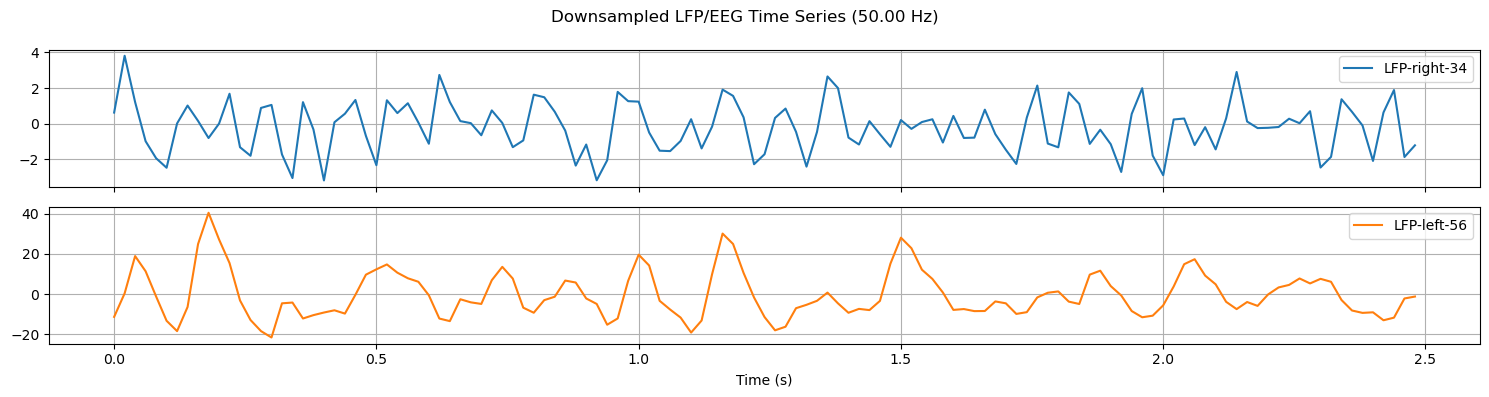

In [7]:
df_dwn = downsample_eeg_dataframe(df=df,
                                  original_fs=2000,
                                  target_fs=50,
                                  plot=True)

In [8]:
right = df_dwn['LFP-right-34']
left = df_dwn['LFP-left-56']

In [9]:
# Slicing both time-series
left_sliced = sample_time_series_slices(left, slice_length = 2.5, n_slices = 10)
right_sliced = sample_time_series_slices(right, slice_length = 2.5, n_slices = 10)

--- Performing Systematic Slicing ---

--- Time Series Slicing Summary ---
Number of slices generated: 10
Length of each slice: 2.5s (125 points at 50.00 Hz)
Time intervals of slices:
  - Slice 1: 0.0000s to 2.4800s
  - Slice 2: 126.2200s to 128.7000s
  - Slice 3: 252.4400s to 254.9200s
  - Slice 4: 378.6600s to 381.1400s
  - Slice 5: 504.8800s to 507.3600s
  - Slice 6: 631.1000s to 633.5800s
  - Slice 7: 757.3200s to 759.8000s
  - Slice 8: 883.5400s to 886.0200s
  - Slice 9: 1009.7600s to 1012.2400s
  - Slice 10: 1136.0000s to 1138.4800s
--- Performing Systematic Slicing ---

--- Time Series Slicing Summary ---
Number of slices generated: 10
Length of each slice: 2.5s (125 points at 50.00 Hz)
Time intervals of slices:
  - Slice 1: 0.0000s to 2.4800s
  - Slice 2: 126.2200s to 128.7000s
  - Slice 3: 252.4400s to 254.9200s
  - Slice 4: 378.6600s to 381.1400s
  - Slice 5: 504.8800s to 507.3600s
  - Slice 6: 631.1000s to 633.5800s
  - Slice 7: 757.3200s to 759.8000s
  - Slice 8: 883.5400s 

<Axes: xlabel='Time (s)'>

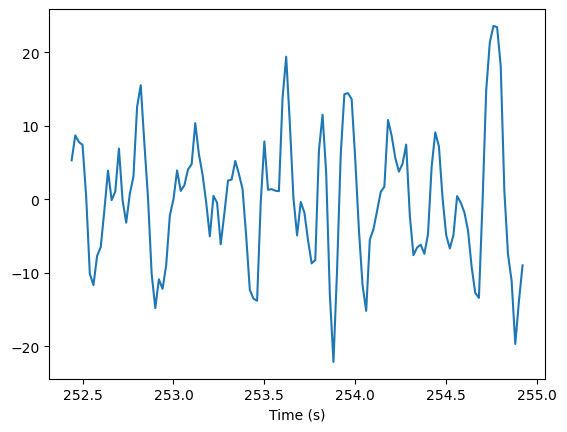

In [51]:
left_sliced[2].plot()

# Doing the TDA magic

In [24]:
from gtda.time_series import SingleTakensEmbedding
from gtda.time_series import TakensEmbedding
import itertools

# --- Plotting Libraries ---
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceEntropy

from eeg_utils import fit_embedder, filter_persistence_diagram, extract_features

# --- Set Plotting Themes to Light Mode ---
pio.templates.default = "plotly_white" # For plotly and giotto-tda plots
plt.style.use('default') # For matplotlib plots


In [6]:
import eeg_utils
importlib.reload(eeg_utils)
from eeg_utils import *

## The current situation of the data
- Down sampled to 50 Hz
- Sliced into 10 pieces of 2.5 seconds.
- Variables are left_sliced[i] and right_sliced[i]

In [11]:
max_embedding_dim = 10
max_time_delay = 10
stride = 1

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dim,
    stride=stride,
    n_jobs=-1
)

In [12]:
left_embeddings = []
for slice in range(len(left_sliced)):
    print(f"Slice {slice + 1}:")
    left_embeddings.append(fit_embedder(embedder, left_sliced[slice]))


Slice 1:
Shape of embedded time series: (117, 3)
Optimal embedding dimension is 3 and time delay is 4
Slice 2:
Shape of embedded time series: (124, 2)
Optimal embedding dimension is 2 and time delay is 1
Slice 3:
Shape of embedded time series: (85, 5)
Optimal embedding dimension is 5 and time delay is 10
Slice 4:
Shape of embedded time series: (85, 5)
Optimal embedding dimension is 5 and time delay is 10
Slice 5:
Shape of embedded time series: (98, 4)
Optimal embedding dimension is 4 and time delay is 9
Slice 6:
Shape of embedded time series: (98, 4)
Optimal embedding dimension is 4 and time delay is 9
Slice 7:
Shape of embedded time series: (117, 5)
Optimal embedding dimension is 5 and time delay is 2
Slice 8:
Shape of embedded time series: (117, 3)
Optimal embedding dimension is 3 and time delay is 4
Slice 9:
Shape of embedded time series: (107, 4)
Optimal embedding dimension is 4 and time delay is 6
Slice 10:
Shape of embedded time series: (124, 2)
Optimal embedding dimension is 2 a

In [14]:
right_embeddings = []
for slice in range(len(right_sliced)):
    print(f"Slice {slice + 1}:")
    right_embeddings.append(fit_embedder(embedder, right_sliced[slice]))

Slice 1:
Shape of embedded time series: (107, 4)
Optimal embedding dimension is 4 and time delay is 6
Slice 2:
Shape of embedded time series: (89, 5)
Optimal embedding dimension is 5 and time delay is 9
Slice 3:
Shape of embedded time series: (110, 4)
Optimal embedding dimension is 4 and time delay is 5
Slice 4:
Shape of embedded time series: (119, 4)
Optimal embedding dimension is 4 and time delay is 2
Slice 5:
Shape of embedded time series: (113, 5)
Optimal embedding dimension is 5 and time delay is 3
Slice 6:
Shape of embedded time series: (110, 4)
Optimal embedding dimension is 4 and time delay is 5
Slice 7:
Shape of embedded time series: (117, 5)
Optimal embedding dimension is 5 and time delay is 2
Slice 8:
Shape of embedded time series: (104, 4)
Optimal embedding dimension is 4 and time delay is 7
Slice 9:
Shape of embedded time series: (101, 5)
Optimal embedding dimension is 5 and time delay is 6
Slice 10:
Shape of embedded time series: (119, 4)
Optimal embedding dimension is 4 

In [63]:
plot_point_cloud(left_embeddings[5])

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

In [45]:
left_embedded_pca = pca.fit_transform(left_embedded)
plot_point_cloud(left_embedded_pca)

In [21]:
right_embedded_pca = pca.fit_transform(right_embedded)
plot_point_cloud(right_embedded_pca)

In [17]:
# Assuming you have your VietorisRipsPersistence object initialized
homology_dims = [0, 1, 2, 3]
persistence = VietorisRipsPersistence(homology_dimensions=homology_dims, n_jobs=-1)

# Create lists to store the diagrams for each slice
left_diagrams = []
right_diagrams = []

# --- Process Left Embeddings ---
print("--- Processing Left Channel Slices ---")
for i, embedding in enumerate(left_embeddings):
    print(f"Calculating persistence for slice {i+1}...")

    # Reshape the 2D embedding to 3D (1, n_points, n_dimensions)
    embedding_3d = embedding[None, :, :]

    # Calculate the persistence diagram
    diagram = persistence.fit_transform(embedding_3d)

    # Add the resulting diagram to our list
    left_diagrams.append(diagram)

# --- Process Right Embeddings ---
print("\\n--- Processing Right Channel Slices ---")
for i, embedding in enumerate(right_embeddings):
    print(f"Calculating persistence for slice {i+1}...")

    # Reshape and transform
    embedding_3d = embedding[None, :, :]
    diagram = persistence.fit_transform(embedding_3d)

    # Add to the list
    right_diagrams.append(diagram)

--- Processing Left Channel Slices ---
Calculating persistence for slice 1...
Calculating persistence for slice 2...
Calculating persistence for slice 3...
Calculating persistence for slice 4...
Calculating persistence for slice 5...
Calculating persistence for slice 6...
Calculating persistence for slice 7...
Calculating persistence for slice 8...
Calculating persistence for slice 9...
Calculating persistence for slice 10...
\n--- Processing Right Channel Slices ---
Calculating persistence for slice 1...
Calculating persistence for slice 2...
Calculating persistence for slice 3...
Calculating persistence for slice 4...
Calculating persistence for slice 5...
Calculating persistence for slice 6...
Calculating persistence for slice 7...
Calculating persistence for slice 8...
Calculating persistence for slice 9...
Calculating persistence for slice 10...


In [18]:
# Now, left_diagrams and right_diagrams are lists of persistence diagrams.
# You can inspect the first one:
print("Example of a calculated diagram's shape:")
print(left_diagrams[0].shape)

# You can then plot one of them just like before:
print("Plotting the diagram for the first slice of the left channel:")

plot_diagram(left_diagrams[3][0])

Example of a calculated diagram's shape:
(1, 145, 3)
Plotting the diagram for the first slice of the left channel:


In [26]:
# --- Create Subplot Titles ---
left_titles = [f"Left Slice {i+1}" for i in range(len(left_diagrams))]
right_titles = [f"Right Slice {i+1}" for i in range(len(right_diagrams))]

# --- Create a 4x5 Figure with Subplots ---
fig = make_subplots(
    rows=4,
    cols=5,
    subplot_titles=(left_titles + right_titles)
)

# Define colors for the different homology dimensions
dim_colors = {
    0: 'blue',
    1: 'red',
    2: 'green',
    3: 'purple'
}

# --- Add Traces for Left Channel Diagrams (Rows 1-2) ---
for i, diagram_3d in enumerate(left_diagrams):
    # Correctly calculate row and column for a 5-column grid
    row = (i // 5) + 1
    col = (i % 5) + 1

    diagram_2d = diagram_3d[0]

    for dim in sorted(dim_colors.keys()):
        dim_mask = diagram_2d[:, 2] == dim
        birth = diagram_2d[dim_mask, 0]
        death = diagram_2d[dim_mask, 1]
        finite_mask = np.isfinite(death)

        fig.add_trace(
            go.Scatter(
                x=birth[finite_mask],
                y=death[finite_mask],
                mode='markers',
                marker_color=dim_colors.get(dim),
                name=f'H{dim}',
                legendgroup=f'H{dim}',
                showlegend=(i == 0)  # Show legend only on the very first plot
            ),
            row=row,
            col=col
        )

    max_val = np.max(diagram_2d[np.isfinite(diagram_2d[:, 1])]) if np.any(np.isfinite(diagram_2d[:, 1])) else 1
    fig.add_shape(
        type="line", x0=0, y0=0, x1=max_val, y1=max_val,
        line=dict(color="black", width=1, dash="dash"),
        row=row, col=col
    )

# --- Add Traces for Right Channel Diagrams (Rows 3-4) ---
for i, diagram_3d in enumerate(right_diagrams):
    # Calculate row and column, starting from row 3
    row = (i // 5) + 3
    col = (i % 5) + 1

    diagram_2d = diagram_3d[0]

    for dim in sorted(dim_colors.keys()):
        dim_mask = diagram_2d[:, 2] == dim
        birth = diagram_2d[dim_mask, 0]
        death = diagram_2d[dim_mask, 1]
        finite_mask = np.isfinite(death)

        fig.add_trace(
            go.Scatter(
                x=birth[finite_mask],
                y=death[finite_mask],
                mode='markers',
                marker_color=dim_colors.get(dim),
                name=f'H{dim}',
                legendgroup=f'H{dim}',
                showlegend=False  # Hide legends for all other plots
            ),
            row=row,
            col=col
        )

    max_val = np.max(diagram_2d[np.isfinite(diagram_2d[:, 1])]) if np.any(np.isfinite(diagram_2d[:, 1])) else 1
    fig.add_shape(
        type="line", x0=0, y0=0, x1=max_val, y1=max_val,
        line=dict(color="black", width=1, dash="dash"),
        row=row, col=col
    )

# --- Update Layout and Axis Titles ---
fig.update_layout(
    height=1200,  # Increased height for 4 rows
    width=1600,
    title_text="Persistence Diagrams for All Slices",
    title_x=0.5,
    legend_title_text='Homology Dimension',
    plot_bgcolor='white'
)

fig.update_xaxes(title_text="Birth", showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(title_text="Death", showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

# Feature Extraction

## Persistence Entropy

In [35]:
PE = PersistenceEntropy()
left_pe_features = [PE.fit_transform(slice) for slice in left_diagrams]
for feat in range(len(left_pe_features)):
    print(f"Slice {feat + 1}: {left_pe_features[feat]}")

Slice 1: [[ 6.71149573  4.07966102  0.87448739 -1.        ]]
Slice 2: [[ 6.37952809  3.19442294 -1.         -1.        ]]
Slice 3: [[ 6.31163604  4.52299061  1.35327691 -1.        ]]
Slice 4: [[6.35271298 5.1278129  3.67318269 1.53829815]]
Slice 5: [[ 6.55674523  4.77772987  3.21384842 -1.        ]]
Slice 6: [[ 6.53976746  5.20239037  2.99863082 -1.        ]]
Slice 7: [[6.73914449 5.64146126 3.82029233 0.76814304]]
Slice 8: [[ 6.52326861  4.46243859  0.52473616 -1.        ]]
Slice 9: [[ 6.57064653  4.98813826  1.96453516 -1.        ]]
Slice 10: [[ 6.60618463  4.11553779 -1.         -1.        ]]


In [34]:
PE = PersistenceEntropy()
right_pe_features = [PE.fit_transform(slice) for slice in right_diagrams]
for feat in range(len(right_pe_features)):
    print(f"Slice {feat + 1}: {right_pe_features[feat]}")

Slice 1: [[ 6.67442298  5.27774642  3.29244485 -1.        ]]
Slice 2: [[6.3858829  5.04237243 2.8588465  0.        ]]
Slice 3: [[6.66872315 5.19418179 3.46376664 0.87107105]]
Slice 4: [[6.78571954 5.5020183  3.36902544 1.39617059]]
Slice 5: [[6.70970297 5.36710521 3.21100031 0.        ]]
Slice 6: [[6.70874653 5.46460048 3.30265116 0.        ]]
Slice 7: [[6.77996077 5.46476627 3.24790738 0.99616861]]
Slice 8: [[ 6.57930556  4.962584    2.21889693 -1.        ]]
Slice 9: [[6.59368802 5.61458412 3.9219618  0.84092441]]
Slice 10: [[6.76694841 5.16531858 2.87868786 0.        ]]


## Other Small Features

In [29]:
left_sm_features = [extract_features(slice, homology_dimensions=homology_dims, verbose=True) for slice in left_diagrams]

--- Extracted Features ---
	h0_feature_count: 116.0000
	h0_avg_lifespan : 5.3220
	h0_max_lifespan : 14.2116
	h0_std_lifespan : 2.4671
	h0_avg_birth    : 0.0000
	h0_avg_death    : 5.3220
	h1_feature_count: 26.0000
	h1_avg_lifespan : 1.5105
	h1_max_lifespan : 4.2225
	h1_std_lifespan : 1.4015
	h1_avg_birth    : 7.4435
	h1_avg_death    : 8.9540
	h2_feature_count: 2.0000
	h2_avg_lifespan : 0.2561
	h2_max_lifespan : 0.3614
	h2_std_lifespan : 0.1053
	h2_avg_birth    : 10.9231
	h2_avg_death    : 11.1792
	h3_feature_count: 1.0000
	h3_avg_lifespan : 0.0000
	h3_max_lifespan : 0.0000
	h3_std_lifespan : 0.0000
	h3_avg_birth    : 0.0000
	h3_avg_death    : 0.0000
--- Extracted Features ---
	h0_feature_count: 123.0000
	h0_avg_lifespan : 2.0739
	h0_max_lifespan : 13.2325
	h0_std_lifespan : 2.2433
	h0_avg_birth    : 0.0000
	h0_avg_death    : 2.0739
	h1_feature_count: 15.0000
	h1_avg_lifespan : 0.5831
	h1_max_lifespan : 1.5829
	h1_std_lifespan : 0.5672
	h1_avg_birth    : 4.0737
	h1_avg_death    : 4.6568


In [30]:
right_sm_features = [extract_features(slice, homology_dimensions=homology_dims, verbose=True) for slice in right_diagrams]

--- Extracted Features ---
	h0_feature_count: 106.0000
	h0_avg_lifespan : 1.1859
	h0_max_lifespan : 2.1687
	h0_std_lifespan : 0.3150
	h0_avg_birth    : 0.0000
	h0_avg_death    : 1.1859
	h1_feature_count: 48.0000
	h1_avg_lifespan : 0.1983
	h1_max_lifespan : 0.5338
	h1_std_lifespan : 0.1262
	h1_avg_birth    : 1.7127
	h1_avg_death    : 1.9110
	h2_feature_count: 13.0000
	h2_avg_lifespan : 0.0950
	h2_max_lifespan : 0.1929
	h2_std_lifespan : 0.0684
	h2_avg_birth    : 2.0941
	h2_avg_death    : 2.1891
	h3_feature_count: 1.0000
	h3_avg_lifespan : 0.0000
	h3_max_lifespan : 0.0000
	h3_std_lifespan : 0.0000
	h3_avg_birth    : 0.0000
	h3_avg_death    : 0.0000
--- Extracted Features ---
	h0_feature_count: 88.0000
	h0_avg_lifespan : 1.7247
	h0_max_lifespan : 3.8152
	h0_std_lifespan : 0.5605
	h0_avg_birth    : 0.0000
	h0_avg_death    : 1.7247
	h1_feature_count: 42.0000
	h1_avg_lifespan : 0.2158
	h1_max_lifespan : 0.6113
	h1_std_lifespan : 0.1493
	h1_avg_birth    : 2.2975
	h1_avg_death    : 2.5133
	h2_